In [51]:
import numpy as np
import pandas as pd
import time
import json
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output, display

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix



I had some difficulties uninstalling pytorch without cuda to replace it so I just created another virtual env and ran it in that. (I think this only needs to be done when you try to run it local)

After activating the venv you can install the pytorch with cuda with the following command.

`pip3 install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html`


In [39]:
device = 'cpu'
#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
train_csv = pd.read_csv("../data/fashion-mnist_train.csv")
test_csv = pd.read_csv("../data/fashion-mnist_test.csv")

In [7]:
# FashionDataset class courtesy of https://www.kaggle.com/pankajj/fashion-mnist-with-pytorch-93-accuracy
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [8]:
# Transform data into Tensor that has a range from 0 to 1
train_set = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(train_set, batch_size=100)

In [9]:
# Mapping label number to a more meaningful label

def output_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat", 
        5: "Sandal", 
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot"
    }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

2


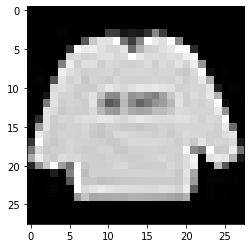

In [10]:
# displaying image using matplotlib imshow()
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [11]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  Pullover, Ankle Boot, Shirt, T-shirt/Top, Dress, Coat, Coat, Sandal, Coat, Bag, 

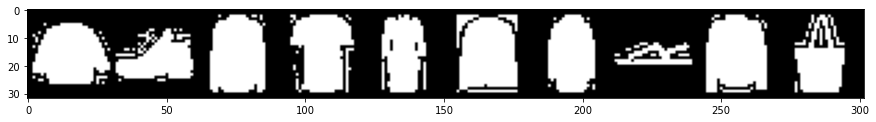

In [12]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

Intuition:
Num of conv layers:
Due to the small size of the individual data (28 x 28) px, we theorize that we don't need a very complicated network. Hence, we're looking at 2 or 3 convolutional layers.

Conv layers kernel size:
Due to the small size of the images and how they look, we think that a smaller kernel size would be better as it can then pick up on smaller details of the images. Hence, we decided on 3x3 kernel size of the convolution layer.

Pooling kernel size and stride
2x2 kernel on max pooling was decided as we didn't want to lose too much information but at the same time leave room for generalization by reducing overfitting.
Stride of 2 was chosen for the first pooling layers since the first layer is more computationally demanding due to larger matrix and same reason as above.
Stride of 1 chosen for second pooling layer to retain more information.

Batch normalization:
Used to avoid overfitting of the model and help to reduce generalization error.
Makes the training faster as well.

Activation function:
ReLU is a non-linear activation function that is idempotent (p(x) == p(p(p.......(x).......)) and hence doesnt suffer from the vanishing gradient problem.
It is also easy to compute.

Dropout:
Apply a regularization technique to preven overfitting of the model.
We plan to use a value between 0.2 to 0.3 as too low of a probability has minimal effect and a value too high will affect the learning of the model.



1. Make a model class (inherits nn.Module class)
2. Add Layers to model class

    a. Convolution layer with kernel size 3*3, padding = 1 (no padding) in 1st layer and padding = 0 in second layer. Stride of 1 in both layers.

    b. Batch normalization layer

    c. Activation function used: ReLU

    d. Max Pooling layer with kernel size of 2 * 2 and stride 2.

        i. flatten out output for dense layer

        ii. 3 fully connected layers with different in/out features

        iii. 1 dropout layer with p=0.25

Summary is as follows:

First conv layer -> Max Pooling layer -> Second conv layer -> second max pooling layer -> Fullyconnected layers -> output

28 * 28 * 3      --> 28 * 28 * 32      --> 14 * 14 * 32      --> 12 * 12 * 64              --> 6 * 6 * 64

Final fully connected layer has 10 output features for 10 types of clothes.

In [70]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            # kernel_size is chosen as 3 due to how small the image is
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

Apparently according to this [question](https://www.quora.com/In-most-papers-I-read-the-CNN-order-is-convolution-relu-max-pooling-So-can-I-change-the-order-to-become-convolution-max-pooling-relu) on quora and some other articles online, 

MaxPool(ReLU(x)) == ReLU(MaxPool(x))

which is essentially saying it's commutative. However, the benefit from performing MaxPooling before computing ReLU is that we get to save computation resources as the data will be smaller and hence computing non-linear layers like ReLU is less intensive. (4 times lesser)

Hence, we may want to change the model to perform MaxPool first

We also decided on a learning rate of 0.001 and a batch size of 100.

Visualizing the results

In [57]:
from collections import OrderedDict, namedtuple
from itertools import product
import os

In [42]:
class RunBuilder():
    @staticmethod
    # forms combinations of hyper params
    def get_runs(params):
        Run = namedtuple('Run', params.keys())

        runs = []

        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

In [71]:
# Helper class, help track loss, accuracy, epoch time, run time, • hyper-parameters etc. Also record to TensorBoard and write into csv, jSOn 
class RunManager():
    def __init__(self): 
        # tracking every epoch count, loss, accuracy, time 
        self.epoch_count = 0 
        self.epoch_loss = 0
        self.epoch_precision = 0
        self.epoch_recall = 0
        self.epoch_f1 = 0
        self.epoch_num_correct = 0 
        self.epoch_start_time = None 
        # tracking every run count, run data, hyper-params used, time
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None 
        # record model, loader and TensorBoard
        self.model = None
        self.loader = None
        self.tb = None 
        # record the count, hyper-param, mndel, loader of each run
        # record sample images and model graph to TensorBoard 
    def begin_run(self, run, model, loader):
        self.run_start_time = time.time()
        self.run_params = run
        self.run_count += 1 

        self.model = model
        self.loader = loader 
        self.tb = SummaryWriter(comment=f'-{run}')

        images, labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)

        self.tb.add_image('images', grid)
        self.tb.add_graph(self.model, images)

    # when run ends, close TensorBoard, zero epoch count
    def end_run(self):
        self.tb.close()
        self.epoch_count = 0

    # zero epoch count, loss, accuracy
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_precision = 0
        self.epoch_recall = 0
        self.epoch_f1 = 0
        self.epoch_num_correct = 0

    def end_epoch(self):
        #calculate epoch duration and run duration(accumulate)
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time 
        # record epoch loss and accuracy
        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct / len(self.loader.dataset)
        precision = self.epoch_precision / (len(self.loader) * 10) # finding average
        recall = self.epoch_recall / (len(self.loader) * 10)
        f1 = self.epoch_f1 / (len(self.loader) * 10)

        # Record epoch loss and accuracy to TensorBoard
        self.tb.add_scalar('Loss', loss, self.epoch_count)
        self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)
        self.tb.add_scalar('Precision', precision, self.epoch_count)
        self.tb.add_scalar('Recall', recall, self.epoch_count)
        self.tb.add_scalar('F1', f1, self.epoch_count)

        # Record norms to TensorBoard
        for name, param in self.model.named_parameters():
            self.tb.add_histogram(name, param, self.epoch_count)
            self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)

        # Write into 'results' OrderedDict for all run related data
        results = OrderedDict()
        results['run'] = self.run_count
        results['epoch'] = self.epoch_count
        results['loss'] = loss
        results['precision'] = precision
        results['recall'] = recall
        results['f1'] = f1
        results['accuracy'] = accuracy
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration

        # Record hyper-params into 'results'
        for k,v in self.run_params._asdict().items():
            results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

        # display epoch information and show progress
        clear_output(wait=True)
        display(df)

    # accumulate number of corrects of batch into entire epoch loss
    def track_loss(self, loss):
        # multiply batch size so batch size can be compared
        self.epoch_loss += loss.item() * self.loader.batch_size

    # accumulate batch into entire epoch precision
    def track_precision(self, precision):
        self.epoch_precision += precision.item()

    # accumulate batch into entire epoch recall
    def track_recall(self, recall):
        self.epoch_recall += recall.item()

    # accumulate batch into entire epoch f1
    def track_f1(self, f1):
        self.epoch_f1 += f1.item()
    
    # accumulate batch into entire epoch
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
    
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    # save into csv, json
    def save(self, fileName):
        if not os.path.exists('./logs'):
            os.makedirs('./logs')
        pd.DataFrame.from_dict(
            self.run_data,
            orient = 'columns'
        ).to_csv(f'./logs/{fileName}.csv')

        with open(f'./logs/{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)



In [58]:
def calculate_precision_recall_f1(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False) -> torch.Tensor:
    '''
    Taken from https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354 with some modifications
    '''
    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2
    
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
        
    
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    return precision, recall, f1

In [44]:
params = OrderedDict(
    lr = [0.01, 0.001]
)
epochs = 2

In [69]:
m = RunManager()
model_list = []

for run in RunBuilder.get_runs(params):
    model = FashionCNN()
    model.to(device)
    loader = train_loader
    optimizer = optim.Adam(model.parameters(), lr=run.lr)
    error = nn.CrossEntropyLoss()

    m.begin_run(run, model, loader)

    for epoch in range(epochs):
        m.begin_epoch()

        for images, labels in loader:
            # Transfering images and labels to GPU if available
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass 
            outputs = model(images)
            loss = error(outputs, labels)
            precision, recall, fscore = calculate_precision_recall_f1(labels, outputs)
            
            # Initializing a gradient as 0 so there is no mixing of gradient among the batches
            optimizer.zero_grad()
            
            #Propagating the error backward
            loss.backward()
            
            # Optimizing the parameters
            optimizer.step()

            m.track_loss(loss)
            m.track_precision(precision)
            m.track_recall(recall)
            m.track_f1(fscore)
            m.track_num_correct(outputs, labels)
        m.end_epoch()
    m.end_run()
    model_list.append(model)

m.save(fileName='run_data')
            

,run,epoch,loss,precision,recall,f1,accuracy,epoch duration,run duration,lr
0,1,1,2.607559,0.604829,0.598005,0.600200,0.788217,59.767446,60.077446,0.010
1,1,2,0.350809,0.615205,0.611442,0.613091,0.874483,52.702924,113.034818,0.010
2,1,3,0.301563,0.616992,0.613742,0.615158,0.891233,47.403666,160.689956,0.010
3,2,1,0.435380,0.611562,0.607550,0.609118,0.845067,53.188012,53.478172,0.001
4,2,2,0.299985,0.616978,0.614467,0.615509,0.893550,49.635167,103.371260,0.001
5,2,3,0.257608,0.618764,0.616545,0.617484,0.908283,49.682783,153.323867,0.001


In [48]:
import os

if not os.path.exists('./diagrams'):
    os.makedirs('./diagrams')

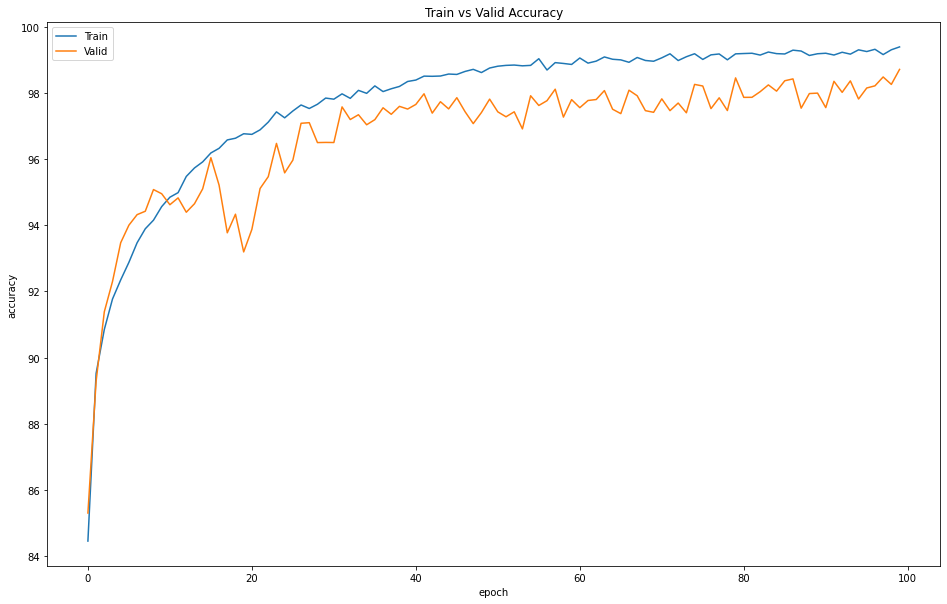

In [111]:
plt.figure(figsize=(16,10))

plt.plot(train_accu)
plt.plot(eval_accu)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.savefig('./diagrams/cNN_Train_vs_Valid_Acc.png')

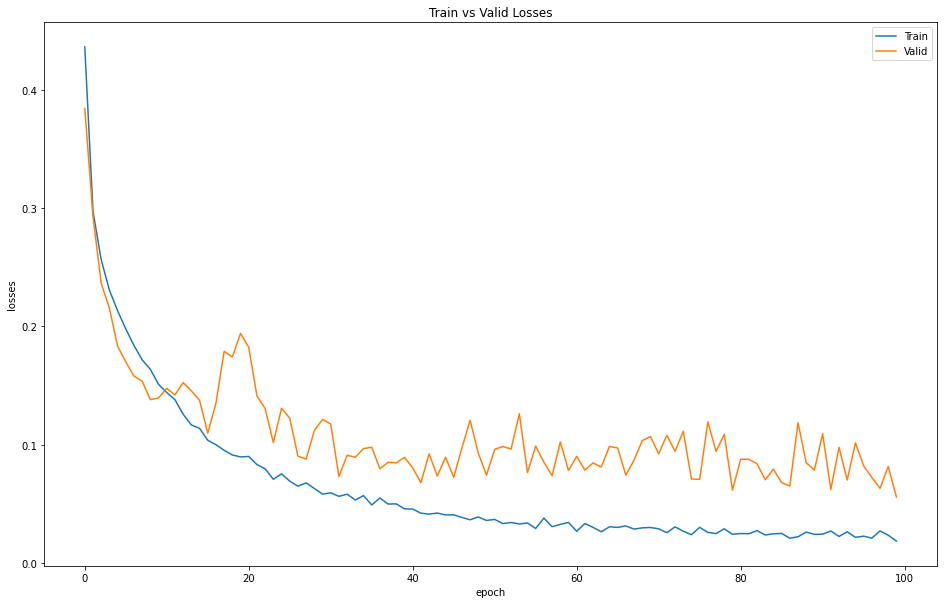

In [112]:
plt.figure(figsize=(16,10))

plt.plot(train_losses)
plt.plot(eval_losses)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.savefig('./diagrams/cNN_Train_vs_Valid_loss.png')

From the graph we can see a downward trend of loss vs epoch. Perhaps a reason for the spikes in loss could be just due to the randomness of the batch sampling. An unlucky sampling could have led to the loss increasing compared to the previous iterations but overall the loss has a downward trend as iterations increase.

In [113]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 98.80%
Accuracy of Trouser: 99.98%
Accuracy of Pullover: 97.43%
Accuracy of Dress: 99.22%
Accuracy of Coat: 97.87%
Accuracy of Sandal: 99.98%
Accuracy of Shirt: 94.80%
Accuracy of Sneaker: 99.50%
Accuracy of Bag: 99.60%
Accuracy of Ankle Boot: 99.93%


In [114]:
# https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())

In [115]:
# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for child in model_children[i].children():
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 2


In [116]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([32, 1, 3, 3])
CONV: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([64, 32, 3, 3])


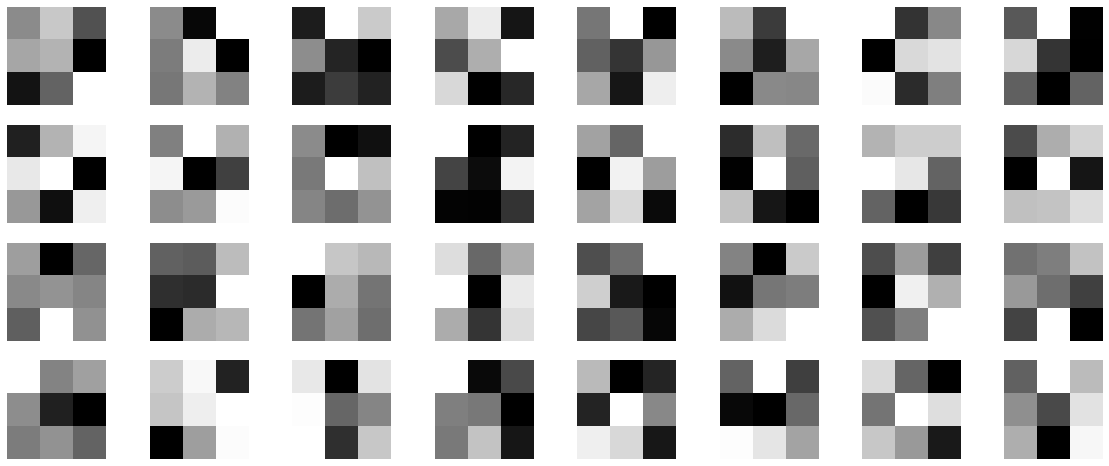

In [117]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0].cpu()):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('./diagrams/filter1.png')
plt.show()

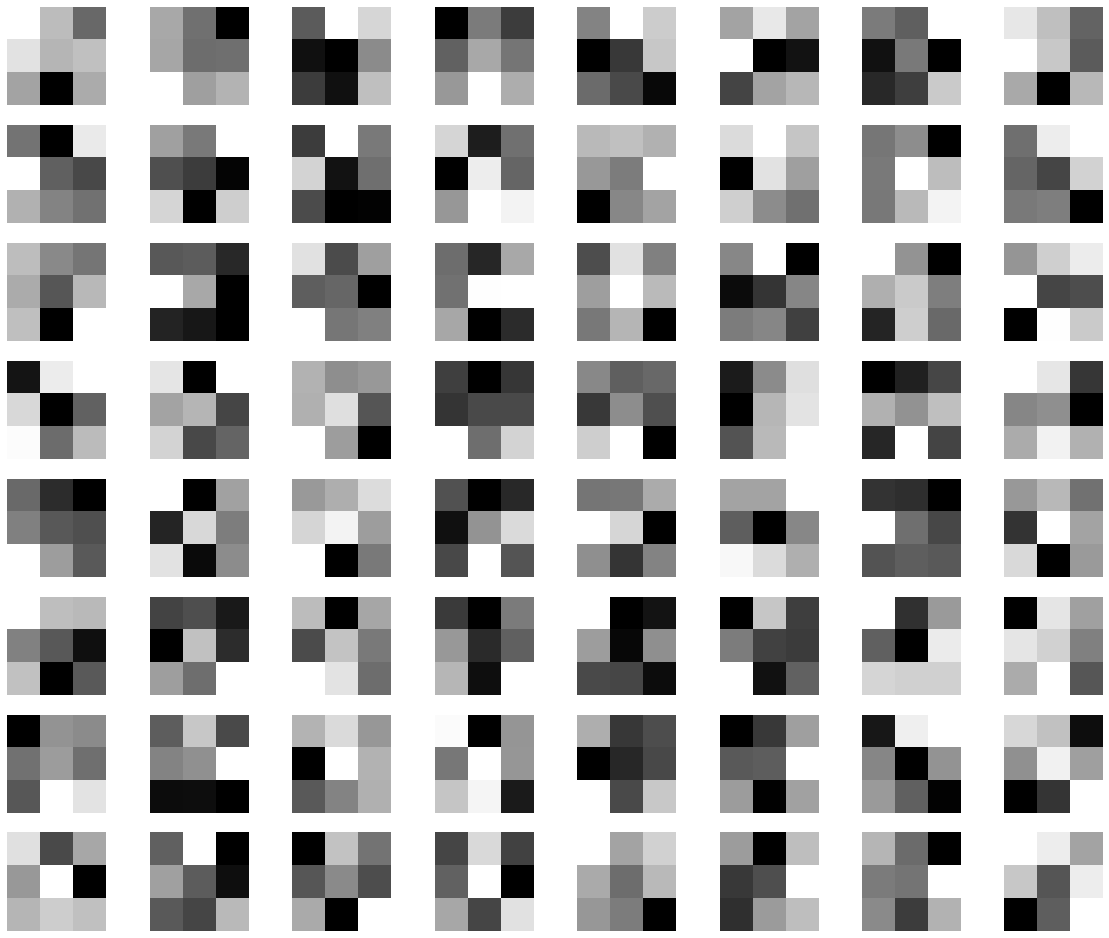

In [118]:
# visualize the second conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[1].cpu()):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('./diagrams/filter2.png')
plt.show()

In [119]:
print(model_weights[0].cpu())

tensor([[[[ 4.6670e-02,  2.6395e-01, -1.5592e-01],
          [ 1.4306e-01,  1.8776e-01, -4.5210e-01],
          [-3.8264e-01, -9.6072e-02,  4.6277e-01]]],


        [[[ 3.6205e-02, -4.6680e-01,  4.8048e-01],
          [-2.0824e-02,  4.0778e-01, -4.9514e-01],
          [-3.8090e-02,  1.8842e-01,  1.1990e-03]]],


        [[[-1.2326e-01,  8.0037e-01,  5.8162e-01],
          [ 3.3757e-01, -8.8342e-02, -2.3783e-01],
          [-1.2106e-01,  7.2113e-03, -9.9444e-02]]],


        [[[ 1.3196e-01,  3.6994e-01, -3.8528e-01],
          [-1.9400e-01,  1.5186e-01,  4.3800e-01],
          [ 3.0053e-01, -4.6135e-01, -3.2111e-01]]],


        [[[-1.6719e-02,  5.1260e-01, -4.7444e-01],
          [-9.4476e-02, -2.7255e-01,  1.1013e-01],
          [ 1.7030e-01, -3.8937e-01,  4.4615e-01]]],


        [[[ 2.7340e-01, -2.3396e-01,  5.4704e-01],
          [ 7.7513e-02, -3.5240e-01,  1.9466e-01],
          [-4.7225e-01,  7.4710e-02,  6.5518e-02]]],


        [[[ 4.2832e-01, -3.4630e-01, -2.2475e-02],
       

In [ ]:
plt.imsave('./diagrams/pullover.png', image.squeeze(), cmap="gray")

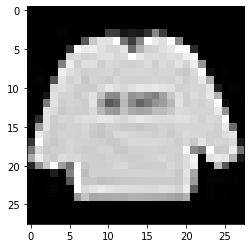

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


In [120]:
import cv2 as cv

# read and visualize an image
img = cv.imread(f"./diagrams/pullover.png")
# img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

In [121]:
# pass the image through all the layers
img = img.to(device)
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

In [122]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig(f"./diagrams/layer_{num_layer}.png")
    # plt.show()
    plt.close()

torch.Size([32, 28, 28])
Saving layer 0 feature maps...
torch.Size([64, 26, 26])
Saving layer 1 feature maps...
